# **Library**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seed_value = 777

In [ ]:

import pandas as pd
import numpy as np
import random
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight


from sklearn.metrics import accuracy_score

from lightgbm import LGBMClassifier

import gensim
from gensim.models import Word2Vec
from gensim.models import FastText

import joblib

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# **Data**

In [ ]:
label_sample_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/백지짱_분야2/Submit/data/Q2_train.csv')
train_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/백지짱_분야2/Submit/data/Q2_train.csv')
test_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/백지짱_분야2/Submit/data/Q2_test.csv')

In [ ]:
print(label_sample_org.shape)
print(train_org.shape)
print(test_org.shape)


(9322, 13)
(9322, 13)
(37671, 12)


In [ ]:
train_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9322 entries, 0 to 9321
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ticketno           9322 non-null   float64
 1   alarmno            9322 non-null   int64  
 2   alarmtime          9322 non-null   object 
 3   alarmlevel         9322 non-null   int64  
 4   alarmmsg_original  9322 non-null   object 
 5   site               9322 non-null   object 
 6   sysname            9322 non-null   object 
 7   unit               9322 non-null   object 
 8   slot               8957 non-null   float64
 9   port               8725 non-null   float64
 10  sva                9322 non-null   object 
 11  root_cause_domain  9322 non-null   object 
 12  root_cause_type    9322 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 946.9+ KB


In [ ]:
test_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37671 entries, 0 to 37670
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ticketno           37671 non-null  float64
 1   alarmno            37671 non-null  int64  
 2   alarmtime          37671 non-null  object 
 3   alarmlevel         37671 non-null  int64  
 4   alarmmsg_original  37671 non-null  object 
 5   site               37671 non-null  object 
 6   sysname            37671 non-null  object 
 7   unit               37671 non-null  object 
 8   slot               34890 non-null  float64
 9   port               34853 non-null  float64
 10  sva                37671 non-null  object 
 11  root_cause_domain  37671 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 3.4+ MB


In [ ]:
label_sample_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9322 entries, 0 to 9321
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ticketno           9322 non-null   float64
 1   alarmno            9322 non-null   int64  
 2   alarmtime          9322 non-null   object 
 3   alarmlevel         9322 non-null   int64  
 4   alarmmsg_original  9322 non-null   object 
 5   site               9322 non-null   object 
 6   sysname            9322 non-null   object 
 7   unit               9322 non-null   object 
 8   slot               8957 non-null   float64
 9   port               8725 non-null   float64
 10  sva                9322 non-null   object 
 11  root_cause_domain  9322 non-null   object 
 12  root_cause_type    9322 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 946.9+ KB


In [ ]:
# 중복행 존재 유무 확인
print('train: ', train_org.duplicated().sum())
print('test: ', test_org.duplicated().sum())

train:  0
test:  0


In [ ]:
# train 데이터 컬럼, 결측치 수, 퍼센트 확인
data_missing = []

for i in train_org.columns:
    missings = train_org[i].isnull().sum()
    if missings > 0:
        data_missing.append(i)
        missings_perc = missings / train_org.shape[0]
        print(f"{i} 칼럼 결측치 수: {missings} ({missings_perc:.2%})")

print('------------------------------')
print(f"결측치가 존재하는 총 컬럼 수: {len(data_missing)}")

slot 칼럼 결측치 수: 365 (3.92%)
port 칼럼 결측치 수: 597 (6.40%)
------------------------------
결측치가 존재하는 총 컬럼 수: 2


In [ ]:
# test 데이터 컬럼, 결측치 수, 퍼센트 확인
data_missing = []

for i in test_org.columns:
    missings = test_org[i].isnull().sum()
    if missings > 0:
        data_missing.append(i)
        missings_perc = missings / test_org.shape[0]
        print(f"{i} 칼럼 결측치 수: {missings} ({missings_perc:.2%})")

print('------------------------------')
print(f"결측치가 존재하는 총 컬럼 수: {len(data_missing)}")

slot 칼럼 결측치 수: 2781 (7.38%)
port 칼럼 결측치 수: 2818 (7.48%)
------------------------------
결측치가 존재하는 총 컬럼 수: 2


In [ ]:
# 두 데이터셋의 unique개수 비교 함수
def unique_count(column):
    print('train unique값 개수 -->', len(train_org[column].unique()))
    print('test unique값 개수 --> ', len(test_org[column].unique()))

In [ ]:
column = ['ticketno', 'alarmno', 'alarmtime', 'alarmlevel', 'alarmmsg_original',
       'site', 'sysname', 'unit', 'slot', 'port', 'sva', 'root_cause_domain']

for i in column:
    print('###', i, '###')
    unique_count(i)
    print('-------------'*2)

### ticketno ###
train unique값 개수 --> 1114
test unique값 개수 -->  4327
--------------------------
### alarmno ###
train unique값 개수 --> 9322
test unique값 개수 -->  37671
--------------------------
### alarmtime ###
train unique값 개수 --> 8132
test unique값 개수 -->  32986
--------------------------
### alarmlevel ###
train unique값 개수 --> 4
test unique값 개수 -->  4
--------------------------
### alarmmsg_original ###
train unique값 개수 --> 31
test unique값 개수 -->  73
--------------------------
### site ###
train unique값 개수 --> 535
test unique값 개수 -->  1329
--------------------------
### sysname ###
train unique값 개수 --> 605
test unique값 개수 -->  1566
--------------------------
### unit ###
train unique값 개수 --> 2
test unique값 개수 -->  666
--------------------------
### slot ###
train unique값 개수 --> 12
test unique값 개수 -->  21
--------------------------
### port ###
train unique값 개수 --> 11
test unique값 개수 -->  41
--------------------------
### sva ###
train unique값 개수 --> 1
test unique값 개수 -->  2
----------

In [ ]:
# ticketno와 alarmno 각각의 중복 개수 확인
for column in train_org.columns[:2]:
    train_dup = train_org[column].duplicated().sum()
    test_dup = test_org[column].duplicated().sum()
    print('Train - {} : {} duplicated values'.format(column, train_dup))
    print('Test - {} : {} duplicated values'.format(column, test_dup))
    print('\n')

Train - ticketno : 8208 duplicated values
Test - ticketno : 33344 duplicated values


Train - alarmno : 0 duplicated values
Test - alarmno : 0 duplicated values




In [ ]:
# 두 데이터셋의 unique값 비교 함수
def unique_result(column):
    print('train unique값 -->', train_org[column].unique())
    print('test unique값 -->', test_org[column].unique())


In [ ]:
column = ['alarmlevel', 'alarmmsg_original',
       'site', 'sysname', 'unit', 'slot', 'port', 'sva', 'root_cause_domain']

for i in column:
    print('###', i, '###')
    unique_result(i)
    print('----------------------------------------------'*2)

### alarmlevel ###
train unique값 --> [5 7 4 3]
test unique값 --> [5 4 3 7]
--------------------------------------------------------------------------------------------
### alarmmsg_original ###
train unique값 --> ['ETH-ERR' 'OPT-LOS' 'DCC-FAIL' 'LSP-LOC' 'ETH-NO-RX-TRAFFIC'
 'OPT-PWR-LOW' 'PSU-FAIL' 'ETH-LINK-FAIL' 'AUTONEGO_MISMATCH'
 'TDM-PW-RMT_FAIL' 'OPT-REMOVE' 'TRK-CONN-MIS' 'ProtectionSwitched'
 'NVRAM-FAIL' 'PW-LOC' 'BATT-LOW' 'BOOTING' 'ETH-NO-TX-TRAFFIC'
 'Restarted' 'OS_MISMATCH' 'UNIT-REM' 'TDM-PW-LOF' 'FAN-48V-FAIL'
 'FAN-FAIL' '48V-FAIL' 'PortShutdown' 'QL_FAIL' 'UNIT-IPC-FAIL'
 'LINK_FAIL_MANUAL' 'PSU-REM' 'OPT-MIS']
test unique값 --> ['Loss Of Signal' 'DDM_RX_PWR_HIGH' 'BATT_ENV_FAIL' 'DDM_RX_PWR_LOW'
 'Remote Defect Indication' 'MEP_LSP_LOC' 'Input Power Degrade Defect'
 'OPT-LOS' 'ETH-LINK-FAIL' 'ETHER_LINK_DOWN (LOCAL_FAULT)'
 'ETHER_LINK_DOWN (LLCF)' 'Server Signal Failure' 'PPP Fail' 'MEP_PWE_LOC'
 'House Keeping Alarm' 'Rx Fail' 'ETHER_TCA_DROP_1D' 'Client Signal Fai

In [ ]:
# target 비율 확인
train_org['root_cause_type'].value_counts()/len(train_org['root_cause_type'])

LinkCut      0.868269
PowerFail    0.077880
UnitFail     0.053851
Name: root_cause_type, dtype: float64

# **Data Cleansing & Pre-Processing**

# 1. alarmmsg의 Data Cleansing

* Data Cleansing을 위한 함수

In [ ]:
# '_' -> '-'
def preprocess_hyphen(text):
    return text.replace('_', '-')

In [ ]:
# 소문자 -> 대문자
def preprocess_uppercase(text):
    return text.upper()


In [ ]:
# 공백 -> ‘-’
def preprocess_blank(text):
    return text.replace(' ', '-')

In [ ]:
# 공백 제거
def preprocess_blank_remove(text):
    return text.replace(' ', '')

In [ ]:
# ‘ :’ 제거
def preprocess_remove_colon(text):
    return text.replace(':', '')

In [ ]:
# 축약어 변환
def preprocess_tolong(text, replacements_msg):

    processed_text = text
    for key, value in replacements_msg.items():
        processed_text = processed_text.replace(key, value)

    return processed_text

* train 데이터의 A제조사

In [ ]:
alarmmsg_unique = train_org['alarmmsg_original'].unique()
msg_uniq = pd.DataFrame(alarmmsg_unique, columns = ['alarmmsg_not_processed'])
msg_uniq

,alarmmsg_not_processed
0,ETH-ERR
1,OPT-LOS
2,DCC-FAIL
3,LSP-LOC
4,ETH-NO-RX-TRAFFIC
5,OPT-PWR-LOW
6,PSU-FAIL
7,ETH-LINK-FAIL
8,AUTONEGO_MISMATCH
9,TDM-PW-RMT_FAIL


In [ ]:
# preprocess_hyphen 함수 사용
msg_uniq['alarmmsg_hyphen'] = msg_uniq['alarmmsg_not_processed'].apply(preprocess_hyphen)
msg_uniq

,alarmmsg_not_processed,alarmmsg_hyphen
0,ETH-ERR,ETH-ERR
1,OPT-LOS,OPT-LOS
2,DCC-FAIL,DCC-FAIL
3,LSP-LOC,LSP-LOC
4,ETH-NO-RX-TRAFFIC,ETH-NO-RX-TRAFFIC
5,OPT-PWR-LOW,OPT-PWR-LOW
6,PSU-FAIL,PSU-FAIL
7,ETH-LINK-FAIL,ETH-LINK-FAIL
8,AUTONEGO_MISMATCH,AUTONEGO-MISMATCH
9,TDM-PW-RMT_FAIL,TDM-PW-RMT-FAIL


In [ ]:
# preprocess_uppercase 함수 사용
msg_uniq['alarmmsg_uppercase'] = msg_uniq['alarmmsg_hyphen'].apply(preprocess_uppercase)
msg_uniq

,alarmmsg_not_processed,alarmmsg_hyphen,alarmmsg_uppercase
0,ETH-ERR,ETH-ERR,ETH-ERR
1,OPT-LOS,OPT-LOS,OPT-LOS
2,DCC-FAIL,DCC-FAIL,DCC-FAIL
3,LSP-LOC,LSP-LOC,LSP-LOC
4,ETH-NO-RX-TRAFFIC,ETH-NO-RX-TRAFFIC,ETH-NO-RX-TRAFFIC
5,OPT-PWR-LOW,OPT-PWR-LOW,OPT-PWR-LOW
6,PSU-FAIL,PSU-FAIL,PSU-FAIL
7,ETH-LINK-FAIL,ETH-LINK-FAIL,ETH-LINK-FAIL
8,AUTONEGO_MISMATCH,AUTONEGO-MISMATCH,AUTONEGO-MISMATCH
9,TDM-PW-RMT_FAIL,TDM-PW-RMT-FAIL,TDM-PW-RMT-FAIL


In [ ]:
# A 제조사의 축약어 변환을 위한 딕셔너리 형태의 단어사전
replacements = {
    'ETH' : 'ETHERNET',
    'ERR' : 'ERROR',
    'IT-REM' : 'IT-REMOVE',
    'U-REM' : 'U-REMOVE',
    'RX' : 'RECEIVE',
    'TX-' : 'TRANSMISSION-',
    'BATT' : 'BATTERY',
    'QL' : 'QUALITY',
    'PWR' : 'POWER',
    'PW' : 'PSEUDOWIRE',
    '-LOS' : '-LOSS-OF-SIGNAL',
    'CONN' : 'CONNECT',
    '-LOC' : '-LOSS-OF-CONNECT',
    'OS-' : 'OPERATING-SYSTEM-',
    'LOF' : 'LOSS-OF-PACKET',
    'PSU' : 'POWER-SUPPLY-UNIT',
    'DCC' : 'DATA-COMMUNICATE-CHANNEL',
    'RMT' : 'REMOTE',
    'TDM' : 'TIME-DIVISION-MULTIPLEX',
    'OPT' : 'OPTICAL',
    'NVRAM' : 'NON-VOLATILE-RANDOM-ACCESS-MEMORY',
    'IPC' : 'INTEGRATED-PACKET-CONTROL',
    'T-MIS' : 'T-MISMATCH',
    'L-MIS' : 'L-MISMATCH',
    'TRK' : 'TRACK',
    'LSP' : 'LABEL-SWITCHED-PATH',
    'AUTONEGO' : 'AUTO-NEGOTIATION',
    'PROTECTIONSWITCHED' : 'PROTECTION-SWITCHED',
    'PORTSHUTDOWN' : 'PORT-SHUTDOWN',
    'FAN-48V-FAIL' : '48V-FAIL'
    }


In [ ]:
# preprocess_tolong, replacements_msg = replacements 함수 사용
msg_uniq['alarmmsg_tolong'] = msg_uniq['alarmmsg_uppercase'].apply(preprocess_tolong, replacements_msg = replacements)
msg_uniq

,alarmmsg_not_processed,alarmmsg_hyphen,alarmmsg_uppercase,alarmmsg_tolong
0,ETH-ERR,ETH-ERR,ETH-ERR,ETHERNET-ERROR
1,OPT-LOS,OPT-LOS,OPT-LOS,OPTICAL-LOSS-OF-SIGNAL
2,DCC-FAIL,DCC-FAIL,DCC-FAIL,DATA-COMMUNICATE-CHANNEL-FAIL
3,LSP-LOC,LSP-LOC,LSP-LOC,LABEL-SWITCHED-PATH-LOSS-OF-CONNECT
4,ETH-NO-RX-TRAFFIC,ETH-NO-RX-TRAFFIC,ETH-NO-RX-TRAFFIC,ETHERNET-NO-RECEIVE-TRAFFIC
5,OPT-PWR-LOW,OPT-PWR-LOW,OPT-PWR-LOW,OPTICAL-POWER-LOW
6,PSU-FAIL,PSU-FAIL,PSU-FAIL,POWER-SUPPLY-UNIT-FAIL
7,ETH-LINK-FAIL,ETH-LINK-FAIL,ETH-LINK-FAIL,ETHERNET-LINK-FAIL
8,AUTONEGO_MISMATCH,AUTONEGO-MISMATCH,AUTONEGO-MISMATCH,AUTO-NEGOTIATION-MISMATCH
9,TDM-PW-RMT_FAIL,TDM-PW-RMT-FAIL,TDM-PW-RMT-FAIL,TIME-DIVISION-MULTIPLEX-PSEUDOWIRE-REMOTE-FAIL


In [ ]:
# 원형 변환 전 후 비교 데이터프레임
final_train_msg = msg_uniq[['alarmmsg_not_processed', 'alarmmsg_tolong']]
final_train_msg

,alarmmsg_not_processed,alarmmsg_tolong
0,ETH-ERR,ETHERNET-ERROR
1,OPT-LOS,OPTICAL-LOSS-OF-SIGNAL
2,DCC-FAIL,DATA-COMMUNICATE-CHANNEL-FAIL
3,LSP-LOC,LABEL-SWITCHED-PATH-LOSS-OF-CONNECT
4,ETH-NO-RX-TRAFFIC,ETHERNET-NO-RECEIVE-TRAFFIC
5,OPT-PWR-LOW,OPTICAL-POWER-LOW
6,PSU-FAIL,POWER-SUPPLY-UNIT-FAIL
7,ETH-LINK-FAIL,ETHERNET-LINK-FAIL
8,AUTONEGO_MISMATCH,AUTO-NEGOTIATION-MISMATCH
9,TDM-PW-RMT_FAIL,TIME-DIVISION-MULTIPLEX-PSEUDOWIRE-REMOTE-FAIL


In [ ]:
# train_org(원데이터)의 알람메시지를 Data Cleansing된 알람메시지로 대체
train_change_msg = pd.merge(train_org, final_train_msg, how = 'inner',left_on = 'alarmmsg_original', right_on = 'alarmmsg_not_processed')
train_change_msg = train_change_msg.drop(['alarmmsg_original', 'alarmmsg_not_processed'], axis = 1)
train_change_msg

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 'alarmtime', 'alarmno' 재정렬
train_change_msg = train_change_msg.sort_values(['alarmtime', 'alarmno'])

In [ ]:
# 최종 데이터프레임
change_col = ['ticketno', 'alarmno', 'alarmtime', 'alarmlevel', 'alarmmsg_tolong','site', 'sysname', 'unit', 'slot', 'port', 'sva', 'root_cause_domain','root_cause_type']


train_change_msg = train_change_msg[change_col]
train_change_msg.rename(columns = {'alarmmsg_tolong' : 'alarmmsg_original'}, inplace = True)
train_change_msg.head()

,ticketno,alarmno,alarmtime,alarmlevel,alarmmsg_original,site,sysname,unit,slot,port,sva,root_cause_domain,root_cause_type
0,21122633.0,1669820428245,2022-12-01 00:02:24+09:00,5,ETHERNET-ERROR,ACEN,acnt,EQPT,3.0,1.0,NSA,A,LinkCut
1,21122633.0,1669821318728,2022-12-01 00:17:15+09:00,5,ETHERNET-ERROR,ACEN,acnt,EQPT,3.0,1.0,NSA,A,LinkCut
2,21122633.0,1669822214832,2022-12-01 00:32:11+09:00,5,ETHERNET-ERROR,ACEN,acnt,EQPT,3.0,1.0,NSA,A,LinkCut
3,21122633.0,1669823114128,2022-12-01 00:47:10+09:00,5,ETHERNET-ERROR,ACEN,acnt,EQPT,3.0,1.0,NSA,A,LinkCut
4,21122633.0,1669824028082,2022-12-01 01:02:24+09:00,5,ETHERNET-ERROR,ACEN,acnt,EQPT,3.0,1.0,NSA,A,LinkCut


* test 데이터 Data Cleansing을 위한 데이터프레임 생성

In [ ]:
# 제조사별 unique한 알람메시지
msg_test = test_org[['root_cause_domain', 'alarmlevel', 'alarmmsg_original']].drop_duplicates().sort_values(['root_cause_domain', 'alarmlevel'])
msg_test

,root_cause_domain,alarmlevel,alarmmsg_original
12494,A,3,ETH-ERR
1568,A,4,PSU-FAIL
3042,A,4,BOOTING
460,A,5,ETH-NO-TX-TRAFFIC
1453,A,5,LSP-LOC
1917,A,5,OPT-PWR-LOW
5965,A,5,ETH-NO-RX-TRAFFIC
5969,A,5,DCC-FAIL
6125,A,5,ETH-ERR
6506,A,5,OPT-PWR-HIGH


* test 데이터의 A제조사

In [ ]:
# test데이터의 A제조사만 추출
msg_A = msg_test.loc[msg_test['root_cause_domain'] == 'A', :]
msg_A

,root_cause_domain,alarmlevel,alarmmsg_original
12494,A,3,ETH-ERR
1568,A,4,PSU-FAIL
3042,A,4,BOOTING
460,A,5,ETH-NO-TX-TRAFFIC
1453,A,5,LSP-LOC
1917,A,5,OPT-PWR-LOW
5965,A,5,ETH-NO-RX-TRAFFIC
5969,A,5,DCC-FAIL
6125,A,5,ETH-ERR
6506,A,5,OPT-PWR-HIGH


In [ ]:
# A제조사의 Data Cleansing 전 알람메시지 모은 데이터프레임
A_msg_uniq = pd.DataFrame(msg_A['alarmmsg_original'].unique(), columns = ['Amsg_not_processed'])
A_msg_uniq

,Amsg_not_processed
0,ETH-ERR
1,PSU-FAIL
2,BOOTING
3,ETH-NO-TX-TRAFFIC
4,LSP-LOC
5,OPT-PWR-LOW
6,ETH-NO-RX-TRAFFIC
7,DCC-FAIL
8,OPT-PWR-HIGH
9,AUTONEGO_MISMATCH


In [ ]:
# preprocess_hyphen 함수 사용
A_msg_uniq['Amsg_hyphen'] = A_msg_uniq['Amsg_not_processed'].apply(preprocess_hyphen)
A_msg_uniq

,Amsg_not_processed,Amsg_hyphen
0,ETH-ERR,ETH-ERR
1,PSU-FAIL,PSU-FAIL
2,BOOTING,BOOTING
3,ETH-NO-TX-TRAFFIC,ETH-NO-TX-TRAFFIC
4,LSP-LOC,LSP-LOC
5,OPT-PWR-LOW,OPT-PWR-LOW
6,ETH-NO-RX-TRAFFIC,ETH-NO-RX-TRAFFIC
7,DCC-FAIL,DCC-FAIL
8,OPT-PWR-HIGH,OPT-PWR-HIGH
9,AUTONEGO_MISMATCH,AUTONEGO-MISMATCH


In [ ]:
# preprocess_blank 함수 사용
A_msg_uniq['Amsg_blank'] = A_msg_uniq['Amsg_hyphen'].apply(preprocess_blank)
A_msg_uniq

,Amsg_not_processed,Amsg_hyphen,Amsg_blank
0,ETH-ERR,ETH-ERR,ETH-ERR
1,PSU-FAIL,PSU-FAIL,PSU-FAIL
2,BOOTING,BOOTING,BOOTING
3,ETH-NO-TX-TRAFFIC,ETH-NO-TX-TRAFFIC,ETH-NO-TX-TRAFFIC
4,LSP-LOC,LSP-LOC,LSP-LOC
5,OPT-PWR-LOW,OPT-PWR-LOW,OPT-PWR-LOW
6,ETH-NO-RX-TRAFFIC,ETH-NO-RX-TRAFFIC,ETH-NO-RX-TRAFFIC
7,DCC-FAIL,DCC-FAIL,DCC-FAIL
8,OPT-PWR-HIGH,OPT-PWR-HIGH,OPT-PWR-HIGH
9,AUTONEGO_MISMATCH,AUTONEGO-MISMATCH,AUTONEGO-MISMATCH


In [ ]:
# preprocess_uppercase 함수 사용
A_msg_uniq['Amsg_uppercase'] = A_msg_uniq['Amsg_blank'].apply(preprocess_uppercase)
A_msg_uniq

,Amsg_not_processed,Amsg_hyphen,Amsg_blank,Amsg_uppercase
0,ETH-ERR,ETH-ERR,ETH-ERR,ETH-ERR
1,PSU-FAIL,PSU-FAIL,PSU-FAIL,PSU-FAIL
2,BOOTING,BOOTING,BOOTING,BOOTING
3,ETH-NO-TX-TRAFFIC,ETH-NO-TX-TRAFFIC,ETH-NO-TX-TRAFFIC,ETH-NO-TX-TRAFFIC
4,LSP-LOC,LSP-LOC,LSP-LOC,LSP-LOC
5,OPT-PWR-LOW,OPT-PWR-LOW,OPT-PWR-LOW,OPT-PWR-LOW
6,ETH-NO-RX-TRAFFIC,ETH-NO-RX-TRAFFIC,ETH-NO-RX-TRAFFIC,ETH-NO-RX-TRAFFIC
7,DCC-FAIL,DCC-FAIL,DCC-FAIL,DCC-FAIL
8,OPT-PWR-HIGH,OPT-PWR-HIGH,OPT-PWR-HIGH,OPT-PWR-HIGH
9,AUTONEGO_MISMATCH,AUTONEGO-MISMATCH,AUTONEGO-MISMATCH,AUTONEGO-MISMATCH


In [ ]:
# preprocess_tolong, replacements_msg = replacements
A_msg_uniq['Amsg_tolong'] = A_msg_uniq['Amsg_uppercase'].apply(preprocess_tolong, replacements_msg = replacements)
A_msg_uniq

,Amsg_not_processed,Amsg_hyphen,Amsg_blank,Amsg_uppercase,Amsg_tolong
0,ETH-ERR,ETH-ERR,ETH-ERR,ETH-ERR,ETHERNET-ERROR
1,PSU-FAIL,PSU-FAIL,PSU-FAIL,PSU-FAIL,POWER-SUPPLY-UNIT-FAIL
2,BOOTING,BOOTING,BOOTING,BOOTING,BOOTING
3,ETH-NO-TX-TRAFFIC,ETH-NO-TX-TRAFFIC,ETH-NO-TX-TRAFFIC,ETH-NO-TX-TRAFFIC,ETHERNET-NO-TRANSMISSION-TRAFFIC
4,LSP-LOC,LSP-LOC,LSP-LOC,LSP-LOC,LABEL-SWITCHED-PATH-LOSS-OF-CONNECT
5,OPT-PWR-LOW,OPT-PWR-LOW,OPT-PWR-LOW,OPT-PWR-LOW,OPTICAL-POWER-LOW
6,ETH-NO-RX-TRAFFIC,ETH-NO-RX-TRAFFIC,ETH-NO-RX-TRAFFIC,ETH-NO-RX-TRAFFIC,ETHERNET-NO-RECEIVE-TRAFFIC
7,DCC-FAIL,DCC-FAIL,DCC-FAIL,DCC-FAIL,DATA-COMMUNICATE-CHANNEL-FAIL
8,OPT-PWR-HIGH,OPT-PWR-HIGH,OPT-PWR-HIGH,OPT-PWR-HIGH,OPTICAL-POWER-HIGH
9,AUTONEGO_MISMATCH,AUTONEGO-MISMATCH,AUTONEGO-MISMATCH,AUTONEGO-MISMATCH,AUTO-NEGOTIATION-MISMATCH


* test 데이터의 B제조사

In [ ]:
# test데이터의 B제조사만 추출
msg_B = msg_test.loc[msg_test['root_cause_domain'] == 'B', :]
msg_B

,root_cause_domain,alarmlevel,alarmmsg_original
2,B,4,DDM_RX_PWR_HIGH
8,B,4,DDM_RX_PWR_LOW
396,B,4,ETHER_TCA_DROP_1D
2338,B,4,ETHER_TCA_CRC_15M
2339,B,4,ETHER_TCA_CRC_1D
2469,B,4,ETHER_PORT_CRC
2612,B,4,BATTERY_FAIL
2864,B,4,ETHER_TCA_DROP_15M
6801,B,4,DC_INPUT_A_FAIL
9306,B,4,DCN_FAIL


In [ ]:
# B제조사의 Data Cleansing 전 알람메시지 모은 데이터프레임
B_msg_uniq = pd.DataFrame(msg_B['alarmmsg_original'].unique(), columns = ['Bmsg_not_processed'])
B_msg_uniq

,Bmsg_not_processed
0,DDM_RX_PWR_HIGH
1,DDM_RX_PWR_LOW
2,ETHER_TCA_DROP_1D
3,ETHER_TCA_CRC_15M
4,ETHER_TCA_CRC_1D
5,ETHER_PORT_CRC
6,BATTERY_FAIL
7,ETHER_TCA_DROP_15M
8,DC_INPUT_A_FAIL
9,DCN_FAIL


In [ ]:
# 괄호 '-'로 변환
B_msg_uniq['Bmsg_no'] = B_msg_uniq['Bmsg_not_processed'].str.replace('(', '-')
B_msg_uniq

<ipython-input-42-8040f37b62ba>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  B_msg_uniq['Bmsg_no'] = B_msg_uniq['Bmsg_not_processed'].str.replace('(', '-')


,Bmsg_not_processed,Bmsg_no
0,DDM_RX_PWR_HIGH,DDM_RX_PWR_HIGH
1,DDM_RX_PWR_LOW,DDM_RX_PWR_LOW
2,ETHER_TCA_DROP_1D,ETHER_TCA_DROP_1D
3,ETHER_TCA_CRC_15M,ETHER_TCA_CRC_15M
4,ETHER_TCA_CRC_1D,ETHER_TCA_CRC_1D
5,ETHER_PORT_CRC,ETHER_PORT_CRC
6,BATTERY_FAIL,BATTERY_FAIL
7,ETHER_TCA_DROP_15M,ETHER_TCA_DROP_15M
8,DC_INPUT_A_FAIL,DC_INPUT_A_FAIL
9,DCN_FAIL,DCN_FAIL


In [ ]:
# 괄호 제거
B_msg_uniq['Bmsg_on'] = B_msg_uniq['Bmsg_no'].str.replace(')', '')
B_msg_uniq

<ipython-input-43-d7d12291b56a>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  B_msg_uniq['Bmsg_on'] = B_msg_uniq['Bmsg_no'].str.replace(')', '')


,Bmsg_not_processed,Bmsg_no,Bmsg_on
0,DDM_RX_PWR_HIGH,DDM_RX_PWR_HIGH,DDM_RX_PWR_HIGH
1,DDM_RX_PWR_LOW,DDM_RX_PWR_LOW,DDM_RX_PWR_LOW
2,ETHER_TCA_DROP_1D,ETHER_TCA_DROP_1D,ETHER_TCA_DROP_1D
3,ETHER_TCA_CRC_15M,ETHER_TCA_CRC_15M,ETHER_TCA_CRC_15M
4,ETHER_TCA_CRC_1D,ETHER_TCA_CRC_1D,ETHER_TCA_CRC_1D
5,ETHER_PORT_CRC,ETHER_PORT_CRC,ETHER_PORT_CRC
6,BATTERY_FAIL,BATTERY_FAIL,BATTERY_FAIL
7,ETHER_TCA_DROP_15M,ETHER_TCA_DROP_15M,ETHER_TCA_DROP_15M
8,DC_INPUT_A_FAIL,DC_INPUT_A_FAIL,DC_INPUT_A_FAIL
9,DCN_FAIL,DCN_FAIL,DCN_FAIL


In [ ]:
# preprocess_blank_remove 함수 사용
B_msg_uniq['Bmsg_blank_remove'] = B_msg_uniq['Bmsg_on'].apply(preprocess_blank_remove)
B_msg_uniq

,Bmsg_not_processed,Bmsg_no,Bmsg_on,Bmsg_blank_remove
0,DDM_RX_PWR_HIGH,DDM_RX_PWR_HIGH,DDM_RX_PWR_HIGH,DDM_RX_PWR_HIGH
1,DDM_RX_PWR_LOW,DDM_RX_PWR_LOW,DDM_RX_PWR_LOW,DDM_RX_PWR_LOW
2,ETHER_TCA_DROP_1D,ETHER_TCA_DROP_1D,ETHER_TCA_DROP_1D,ETHER_TCA_DROP_1D
3,ETHER_TCA_CRC_15M,ETHER_TCA_CRC_15M,ETHER_TCA_CRC_15M,ETHER_TCA_CRC_15M
4,ETHER_TCA_CRC_1D,ETHER_TCA_CRC_1D,ETHER_TCA_CRC_1D,ETHER_TCA_CRC_1D
5,ETHER_PORT_CRC,ETHER_PORT_CRC,ETHER_PORT_CRC,ETHER_PORT_CRC
6,BATTERY_FAIL,BATTERY_FAIL,BATTERY_FAIL,BATTERY_FAIL
7,ETHER_TCA_DROP_15M,ETHER_TCA_DROP_15M,ETHER_TCA_DROP_15M,ETHER_TCA_DROP_15M
8,DC_INPUT_A_FAIL,DC_INPUT_A_FAIL,DC_INPUT_A_FAIL,DC_INPUT_A_FAIL
9,DCN_FAIL,DCN_FAIL,DCN_FAIL,DCN_FAIL


In [ ]:
# preprocess_hyphen 함수 사용
B_msg_uniq['Bmsg_hyphen'] = B_msg_uniq['Bmsg_blank_remove'].apply(preprocess_hyphen)
B_msg_uniq

,Bmsg_not_processed,Bmsg_no,Bmsg_on,Bmsg_blank_remove,Bmsg_hyphen
0,DDM_RX_PWR_HIGH,DDM_RX_PWR_HIGH,DDM_RX_PWR_HIGH,DDM_RX_PWR_HIGH,DDM-RX-PWR-HIGH
1,DDM_RX_PWR_LOW,DDM_RX_PWR_LOW,DDM_RX_PWR_LOW,DDM_RX_PWR_LOW,DDM-RX-PWR-LOW
2,ETHER_TCA_DROP_1D,ETHER_TCA_DROP_1D,ETHER_TCA_DROP_1D,ETHER_TCA_DROP_1D,ETHER-TCA-DROP-1D
3,ETHER_TCA_CRC_15M,ETHER_TCA_CRC_15M,ETHER_TCA_CRC_15M,ETHER_TCA_CRC_15M,ETHER-TCA-CRC-15M
4,ETHER_TCA_CRC_1D,ETHER_TCA_CRC_1D,ETHER_TCA_CRC_1D,ETHER_TCA_CRC_1D,ETHER-TCA-CRC-1D
5,ETHER_PORT_CRC,ETHER_PORT_CRC,ETHER_PORT_CRC,ETHER_PORT_CRC,ETHER-PORT-CRC
6,BATTERY_FAIL,BATTERY_FAIL,BATTERY_FAIL,BATTERY_FAIL,BATTERY-FAIL
7,ETHER_TCA_DROP_15M,ETHER_TCA_DROP_15M,ETHER_TCA_DROP_15M,ETHER_TCA_DROP_15M,ETHER-TCA-DROP-15M
8,DC_INPUT_A_FAIL,DC_INPUT_A_FAIL,DC_INPUT_A_FAIL,DC_INPUT_A_FAIL,DC-INPUT-A-FAIL
9,DCN_FAIL,DCN_FAIL,DCN_FAIL,DCN_FAIL,DCN-FAIL


In [ ]:
# B 제조사의 축약어 변환을 위한 딕셔너리 형태의 단어사전
replacements_B = {
    'DDM' : 'ALARM',
    'RX' : 'RECEIVE',
    'TX' : 'TRANSMISSION',
    'PWR' : 'POWER',
    'ETHER' : 'ETHERNET',
    'TCA' : 'ALARM',
    '1D' : '1-DAY',
    '15M' : '15-MINUTE',
    'CRC' : 'CYCLIC-REDUNDANCY-CHECK',
    'DCN' : 'DATA-COMMUNICATE-NETWORK',
    'DC' : 'BATTERY',
    'BYINSLOT' : 'BY-IN-SLOT',
    'BYRESET' : 'BY-RESET',
    'SFP+' : 'ENHANCED-SMALL-FORM-FACTOR-PLUG',
    'SFP' : 'SMALL-FORM-FACTOR-PLUG',
    'STM1' : 'SYNCHRONOUS-TRANSPORT-MODULE-LEVEL-1',
    'LOS' : 'LOSS-OF-SIGNAL',
    'MEP' : 'MAINTENANCE-END-POINT',
    'LSP' : 'LABEL-SWITCHED-PATH',
    'RDI' : 'RECEIVE-FAIL',
    'BATT-' : 'BATTERY-',
    'ENV' : 'ENVIRONMENT',
    'E-LOC' : 'E-LOSS-OF-CONNECT',
    'P-LOC' : 'P-LOSS-OF-CONNECT',
    'H-LOC' : 'H-LOSS-OF-CONNECT',
    'PWE' : 'PSEUDOWIRE-EMULATION',
    'CSF' : 'CLIENT-SIGNAL-FAIL',
    'SYS' : 'SYSTEM',
    'TEMP' : 'TEMPARATURE',
    'CEP' : 'CLIENT-ENVIRONMENT-PROTECTION',
    'AIS' : 'ALARM',
    'LLCF' : 'LINK-LOST-CARRY-FORWARD'
    }


In [ ]:
# preprocess_tolong, replacements_msg = replacements_B 함수 사용
B_msg_uniq['Bmsg_tolong'] = B_msg_uniq['Bmsg_hyphen'].apply(preprocess_tolong, replacements_msg = replacements_B)
B_msg_uniq

,Bmsg_not_processed,Bmsg_no,Bmsg_on,Bmsg_blank_remove,Bmsg_hyphen,Bmsg_tolong
0,DDM_RX_PWR_HIGH,DDM_RX_PWR_HIGH,DDM_RX_PWR_HIGH,DDM_RX_PWR_HIGH,DDM-RX-PWR-HIGH,ALARM-RECEIVE-POWER-HIGH
1,DDM_RX_PWR_LOW,DDM_RX_PWR_LOW,DDM_RX_PWR_LOW,DDM_RX_PWR_LOW,DDM-RX-PWR-LOW,ALARM-RECEIVE-POWER-LOW
2,ETHER_TCA_DROP_1D,ETHER_TCA_DROP_1D,ETHER_TCA_DROP_1D,ETHER_TCA_DROP_1D,ETHER-TCA-DROP-1D,ETHERNET-ALARM-DROP-1-DAY
3,ETHER_TCA_CRC_15M,ETHER_TCA_CRC_15M,ETHER_TCA_CRC_15M,ETHER_TCA_CRC_15M,ETHER-TCA-CRC-15M,ETHERNET-ALARM-CYCLIC-REDUNDANCY-CHECK-15-MINUTE
4,ETHER_TCA_CRC_1D,ETHER_TCA_CRC_1D,ETHER_TCA_CRC_1D,ETHER_TCA_CRC_1D,ETHER-TCA-CRC-1D,ETHERNET-ALARM-CYCLIC-REDUNDANCY-CHECK-1-DAY
5,ETHER_PORT_CRC,ETHER_PORT_CRC,ETHER_PORT_CRC,ETHER_PORT_CRC,ETHER-PORT-CRC,ETHERNET-PORT-CYCLIC-REDUNDANCY-CHECK
6,BATTERY_FAIL,BATTERY_FAIL,BATTERY_FAIL,BATTERY_FAIL,BATTERY-FAIL,BATTERY-FAIL
7,ETHER_TCA_DROP_15M,ETHER_TCA_DROP_15M,ETHER_TCA_DROP_15M,ETHER_TCA_DROP_15M,ETHER-TCA-DROP-15M,ETHERNET-ALARM-DROP-15-MINUTE
8,DC_INPUT_A_FAIL,DC_INPUT_A_FAIL,DC_INPUT_A_FAIL,DC_INPUT_A_FAIL,DC-INPUT-A-FAIL,BATTERY-INPUT-A-FAIL
9,DCN_FAIL,DCN_FAIL,DCN_FAIL,DCN_FAIL,DCN-FAIL,DATA-COMMUNICATE-NETWORK-FAIL


In [ ]:
# 변환 확인
B_msg_uniq['Bmsg_tolong'].unique()

array(['ALARM-RECEIVE-POWER-HIGH', 'ALARM-RECEIVE-POWER-LOW',
       'ETHERNET-ALARM-DROP-1-DAY',
       'ETHERNET-ALARM-CYCLIC-REDUNDANCY-CHECK-15-MINUTE',
       'ETHERNET-ALARM-CYCLIC-REDUNDANCY-CHECK-1-DAY',
       'ETHERNET-PORT-CYCLIC-REDUNDANCY-CHECK', 'BATTERY-FAIL',
       'ETHERNET-ALARM-DROP-15-MINUTE', 'BATTERY-INPUT-A-FAIL',
       'DATA-COMMUNICATE-NETWORK-FAIL', 'UNIT-INIT-BY-IN-SLOT',
       'UNIT-INIT-BY-RESET', 'UNIT-OUT',
       'MODULE-OUT-SMALL-FORM-FACTOR-PLUG',
       'SYNCHRONOUS-TRANSPORT-MODULE-LEVEL-1-LOSS-OF-SIGNAL',
       'MAINTENANCE-END-POINT-LABEL-SWITCHED-PATH-RECEIVE-FAIL',
       'BATTERY-ENVIRONMENT-FAIL',
       'MAINTENANCE-END-POINT-LABEL-SWITCHED-PATH-LOSS-OF-CONNECT',
       'MAINTENANCE-END-POINT-PSEUDOWIRE-EMULATION-LOSS-OF-CONNECT',
       'MAINTENANCE-END-POINT-PSEUDOWIRE-EMULATION-CLIENT-SIGNAL-FAIL',
       'SYSTEM-TEMPARATURE-LOW', 'CLIENT-ENVIRONMENT-PROTECTION-ALARM',
       'ETHERNET-LINK-DOWN-LOCAL-FAULT',
       'ETHERNET-LINK-DOWN-

* test 데이터의 C제조사

In [ ]:
# test데이터의 C제조사만 추출
msg_C = msg_test.loc[msg_test['root_cause_domain'] == 'C', :]
msg_C

,root_cause_domain,alarmlevel,alarmmsg_original
10,C,3,Remote Defect Indication
165,C,4,PPP Fail
309,C,4,Rx Fail
395,C,4,Input Power Degrade Defect
4399,C,4,OAM Loss Of Continuity
4432,C,4,OAM RDI
6414,C,4,Improper Removal
6717,C,4,OAMLoss Of Continuity
7378,C,4,Manual (Management) Removal
7765,C,4,Procedure Error


In [ ]:
# C제조사의 Data Cleansing 전 알람메시지 모은 데이터프레임
C_msg_uniq = pd.DataFrame(msg_C['alarmmsg_original'].unique(), columns = ['Cmsg_not_processed'])
C_msg_uniq

,Cmsg_not_processed
0,Remote Defect Indication
1,PPP Fail
2,Rx Fail
3,Input Power Degrade Defect
4,OAM Loss Of Continuity
5,OAM RDI
6,Improper Removal
7,OAMLoss Of Continuity
8,Manual (Management) Removal
9,Procedure Error


In [ ]:
# 괄호 제거
C_msg_uniq['Cmsg_no'] = C_msg_uniq['Cmsg_not_processed'].str.replace('(', '')
C_msg_uniq

<ipython-input-51-10859d41cd73>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  C_msg_uniq['Cmsg_no'] = C_msg_uniq['Cmsg_not_processed'].str.replace('(', '')


,Cmsg_not_processed,Cmsg_no
0,Remote Defect Indication,Remote Defect Indication
1,PPP Fail,PPP Fail
2,Rx Fail,Rx Fail
3,Input Power Degrade Defect,Input Power Degrade Defect
4,OAM Loss Of Continuity,OAM Loss Of Continuity
5,OAM RDI,OAM RDI
6,Improper Removal,Improper Removal
7,OAMLoss Of Continuity,OAMLoss Of Continuity
8,Manual (Management) Removal,Manual Management) Removal
9,Procedure Error,Procedure Error


In [ ]:
# 괄호 제거
C_msg_uniq['Cmsg_on'] = C_msg_uniq['Cmsg_no'].str.replace(')', '')
C_msg_uniq

<ipython-input-52-8a65a9da06ab>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  C_msg_uniq['Cmsg_on'] = C_msg_uniq['Cmsg_no'].str.replace(')', '')


,Cmsg_not_processed,Cmsg_no,Cmsg_on
0,Remote Defect Indication,Remote Defect Indication,Remote Defect Indication
1,PPP Fail,PPP Fail,PPP Fail
2,Rx Fail,Rx Fail,Rx Fail
3,Input Power Degrade Defect,Input Power Degrade Defect,Input Power Degrade Defect
4,OAM Loss Of Continuity,OAM Loss Of Continuity,OAM Loss Of Continuity
5,OAM RDI,OAM RDI,OAM RDI
6,Improper Removal,Improper Removal,Improper Removal
7,OAMLoss Of Continuity,OAMLoss Of Continuity,OAMLoss Of Continuity
8,Manual (Management) Removal,Manual Management) Removal,Manual Management Removal
9,Procedure Error,Procedure Error,Procedure Error


In [ ]:
# preprocess_remove_colon 함수 사용
C_msg_uniq['Cmsg_colon'] = C_msg_uniq['Cmsg_on'].apply(preprocess_remove_colon)
C_msg_uniq

,Cmsg_not_processed,Cmsg_no,Cmsg_on,Cmsg_colon
0,Remote Defect Indication,Remote Defect Indication,Remote Defect Indication,Remote Defect Indication
1,PPP Fail,PPP Fail,PPP Fail,PPP Fail
2,Rx Fail,Rx Fail,Rx Fail,Rx Fail
3,Input Power Degrade Defect,Input Power Degrade Defect,Input Power Degrade Defect,Input Power Degrade Defect
4,OAM Loss Of Continuity,OAM Loss Of Continuity,OAM Loss Of Continuity,OAM Loss Of Continuity
5,OAM RDI,OAM RDI,OAM RDI,OAM RDI
6,Improper Removal,Improper Removal,Improper Removal,Improper Removal
7,OAMLoss Of Continuity,OAMLoss Of Continuity,OAMLoss Of Continuity,OAMLoss Of Continuity
8,Manual (Management) Removal,Manual Management) Removal,Manual Management Removal,Manual Management Removal
9,Procedure Error,Procedure Error,Procedure Error,Procedure Error


In [ ]:
# preprocess_blank 함수 사용
C_msg_uniq['Cmsg_blank'] = C_msg_uniq['Cmsg_colon'].apply(preprocess_blank)
C_msg_uniq

,Cmsg_not_processed,Cmsg_no,Cmsg_on,Cmsg_colon,Cmsg_blank
0,Remote Defect Indication,Remote Defect Indication,Remote Defect Indication,Remote Defect Indication,Remote-Defect-Indication
1,PPP Fail,PPP Fail,PPP Fail,PPP Fail,PPP-Fail
2,Rx Fail,Rx Fail,Rx Fail,Rx Fail,Rx-Fail
3,Input Power Degrade Defect,Input Power Degrade Defect,Input Power Degrade Defect,Input Power Degrade Defect,Input-Power-Degrade-Defect
4,OAM Loss Of Continuity,OAM Loss Of Continuity,OAM Loss Of Continuity,OAM Loss Of Continuity,OAM-Loss-Of-Continuity
5,OAM RDI,OAM RDI,OAM RDI,OAM RDI,OAM-RDI
6,Improper Removal,Improper Removal,Improper Removal,Improper Removal,Improper-Removal
7,OAMLoss Of Continuity,OAMLoss Of Continuity,OAMLoss Of Continuity,OAMLoss Of Continuity,OAMLoss-Of-Continuity
8,Manual (Management) Removal,Manual Management) Removal,Manual Management Removal,Manual Management Removal,Manual-Management-Removal
9,Procedure Error,Procedure Error,Procedure Error,Procedure Error,Procedure-Error


In [ ]:
# preprocess_uppercase 함수 사용
C_msg_uniq['Cmsg_uppercase'] = C_msg_uniq['Cmsg_blank'].apply(preprocess_uppercase)
C_msg_uniq

,Cmsg_not_processed,Cmsg_no,Cmsg_on,Cmsg_colon,Cmsg_blank,Cmsg_uppercase
0,Remote Defect Indication,Remote Defect Indication,Remote Defect Indication,Remote Defect Indication,Remote-Defect-Indication,REMOTE-DEFECT-INDICATION
1,PPP Fail,PPP Fail,PPP Fail,PPP Fail,PPP-Fail,PPP-FAIL
2,Rx Fail,Rx Fail,Rx Fail,Rx Fail,Rx-Fail,RX-FAIL
3,Input Power Degrade Defect,Input Power Degrade Defect,Input Power Degrade Defect,Input Power Degrade Defect,Input-Power-Degrade-Defect,INPUT-POWER-DEGRADE-DEFECT
4,OAM Loss Of Continuity,OAM Loss Of Continuity,OAM Loss Of Continuity,OAM Loss Of Continuity,OAM-Loss-Of-Continuity,OAM-LOSS-OF-CONTINUITY
5,OAM RDI,OAM RDI,OAM RDI,OAM RDI,OAM-RDI,OAM-RDI
6,Improper Removal,Improper Removal,Improper Removal,Improper Removal,Improper-Removal,IMPROPER-REMOVAL
7,OAMLoss Of Continuity,OAMLoss Of Continuity,OAMLoss Of Continuity,OAMLoss Of Continuity,OAMLoss-Of-Continuity,OAMLOSS-OF-CONTINUITY
8,Manual (Management) Removal,Manual Management) Removal,Manual Management Removal,Manual Management Removal,Manual-Management-Removal,MANUAL-MANAGEMENT-REMOVAL
9,Procedure Error,Procedure Error,Procedure Error,Procedure Error,Procedure-Error,PROCEDURE-ERROR


In [ ]:
# C 제조사의 축약어 변환을 위한 딕셔너리 형태의 단어사전
replacements_C = {
    'PPP' : 'ETHERNET',
    'RX' : 'RECEIVE',
    'OAMLOSS' : 'OAM-LOSS',
    'OAM' : 'OPERATION-AND-MAINTENANCE',
    'CONTINUITY' : 'CONNECT',
    'REMOTE-DEFECT-INDICATION' : 'ALARM',
    'RDI' : 'RECEIVE-FAIL',
    'IOC' : 'INPUT-OUTPUT-CONTROLLER',
    'FAILURE' : 'FAIL',
    'MEG' : 'MULTICAST-ETHERNET-GROUP',
    'NE-' : 'NETWORK-ELEMENT-',
    'MNG' : 'MANAGEMENT',
    'INTERF' : 'INTERFACE',
    'HOUSE-KEEPING-ALARM' : 'ALARM',
    'REMOVAL' : 'REMOVE',
    'CONNECTIVITY' : 'CONNECT',
    'REACHABLE' : 'REACH',
    'LINKS' : 'LINK',
    'HARDWARE' : 'UNIT',
    'CONTROLLER' : 'UNIT',
    'DEGRADE' : 'LOW',
    'WITH-MATRIX-' : '',
    '-RAISE' : '',
    'NOT' : 'NO'
    }

In [ ]:
# preprocess_tolong, replacements_msg = replacements_C 함수 사용
C_msg_uniq['Cmsg_tolong'] = C_msg_uniq['Cmsg_uppercase'].apply(preprocess_tolong, replacements_msg = replacements_C)
C_msg_uniq

,Cmsg_not_processed,Cmsg_no,Cmsg_on,Cmsg_colon,Cmsg_blank,Cmsg_uppercase,Cmsg_tolong
0,Remote Defect Indication,Remote Defect Indication,Remote Defect Indication,Remote Defect Indication,Remote-Defect-Indication,REMOTE-DEFECT-INDICATION,ALARM
1,PPP Fail,PPP Fail,PPP Fail,PPP Fail,PPP-Fail,PPP-FAIL,ETHERNET-FAIL
2,Rx Fail,Rx Fail,Rx Fail,Rx Fail,Rx-Fail,RX-FAIL,RECEIVE-FAIL
3,Input Power Degrade Defect,Input Power Degrade Defect,Input Power Degrade Defect,Input Power Degrade Defect,Input-Power-Degrade-Defect,INPUT-POWER-DEGRADE-DEFECT,INPUT-POWER-LOW-DEFECT
4,OAM Loss Of Continuity,OAM Loss Of Continuity,OAM Loss Of Continuity,OAM Loss Of Continuity,OAM-Loss-Of-Continuity,OAM-LOSS-OF-CONTINUITY,OPERATION-AND-MAINTENANCE-LOSS-OF-CONNECT
5,OAM RDI,OAM RDI,OAM RDI,OAM RDI,OAM-RDI,OAM-RDI,OPERATION-AND-MAINTENANCE-RECEIVE-FAIL
6,Improper Removal,Improper Removal,Improper Removal,Improper Removal,Improper-Removal,IMPROPER-REMOVAL,IMPROPER-REMOVE
7,OAMLoss Of Continuity,OAMLoss Of Continuity,OAMLoss Of Continuity,OAMLoss Of Continuity,OAMLoss-Of-Continuity,OAMLOSS-OF-CONTINUITY,OPERATION-AND-MAINTENANCE-LOSS-OF-CONNECT
8,Manual (Management) Removal,Manual Management) Removal,Manual Management Removal,Manual Management Removal,Manual-Management-Removal,MANUAL-MANAGEMENT-REMOVAL,MANUAL-MANAGEMENT-REMOVE
9,Procedure Error,Procedure Error,Procedure Error,Procedure Error,Procedure-Error,PROCEDURE-ERROR,PROCEDURE-ERROR


In [ ]:
# 변환 확인
C_msg_uniq['Cmsg_tolong'].unique()

array(['ALARM', 'ETHERNET-FAIL', 'RECEIVE-FAIL', 'INPUT-POWER-LOW-DEFECT',
       'OPERATION-AND-MAINTENANCE-LOSS-OF-CONNECT',
       'OPERATION-AND-MAINTENANCE-RECEIVE-FAIL', 'IMPROPER-REMOVE',
       'MANUAL-MANAGEMENT-REMOVE', 'PROCEDURE-ERROR',
       'ABNORMAL-CONDITION-LASER-FORCED',
       'INPUT-OUTPUT-UNIT-PAYLOAD-LINK-FAIL', 'LOSS-OF-SIGNAL',
       'SERVER-SIGNAL-FAIL', 'CLIENT-SIGNAL-FAIL', 'LOSS-OF-CONNECT',
       'UNEXPECTED-MULTICAST-ETHERNET-GROUP', 'UNIT-FAIL',
       'UNDERLYING-RESOURCE-UNAVAILABLE', 'REMOTE-FAULT-INDICATION',
       'SYNCHRONIZATION-SIGNAL-FAIL',
       'NETWORK-ELEMENT-NO-REACH-VIA-PRIMARY-MANAGEMENT-INTERFACE',
       'NODE-ISOLATION'], dtype=object)

* djlfaklj


In [ ]:
A_msg_uniq.rename(columns = {'Amsg_not_processed' : 'msg_not_processed'}, inplace = True)
B_msg_uniq.rename(columns = {'Bmsg_not_processed' : 'msg_not_processed'}, inplace = True)
C_msg_uniq.rename(columns = {'Cmsg_not_processed' : 'msg_not_processed'}, inplace = True)

In [ ]:
A_msg_uniq.rename(columns = {'Amsg_tolong' : 'msg_tolong'}, inplace = True)
B_msg_uniq.rename(columns = {'Bmsg_tolong' : 'msg_tolong'}, inplace = True)
C_msg_uniq.rename(columns = {'Cmsg_tolong' : 'msg_tolong'}, inplace = True)

In [ ]:
A_msg_uniq = A_msg_uniq[['msg_not_processed', 'msg_tolong']]
B_msg_uniq = B_msg_uniq[['msg_not_processed', 'msg_tolong']]
C_msg_uniq = C_msg_uniq[['msg_not_processed', 'msg_tolong']]

In [ ]:
A_B_msg = pd.concat([A_msg_uniq, B_msg_uniq], join = 'outer')
A_B_C_msg = pd.concat([A_B_msg, C_msg_uniq], join = 'outer')

In [ ]:
print(A_B_C_msg.shape)
A_B_C_msg.head()

(73, 2)


,msg_not_processed,msg_tolong
0,ETH-ERR,ETHERNET-ERROR
1,PSU-FAIL,POWER-SUPPLY-UNIT-FAIL
2,BOOTING,BOOTING
3,ETH-NO-TX-TRAFFIC,ETHERNET-NO-TRANSMISSION-TRAFFIC
4,LSP-LOC,LABEL-SWITCHED-PATH-LOSS-OF-CONNECT


In [ ]:
test_change_msg = pd.merge(test_org, A_B_C_msg, how = 'left',\
                           left_on = 'alarmmsg_original', right_on = 'msg_not_processed')
test_change_msg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37671 entries, 0 to 37670
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ticketno           37671 non-null  float64
 1   alarmno            37671 non-null  int64  
 2   alarmtime          37671 non-null  object 
 3   alarmlevel         37671 non-null  int64  
 4   alarmmsg_original  37671 non-null  object 
 5   site               37671 non-null  object 
 6   sysname            37671 non-null  object 
 7   unit               37671 non-null  object 
 8   slot               34890 non-null  float64
 9   port               34853 non-null  float64
 10  sva                37671 non-null  object 
 11  root_cause_domain  37671 non-null  object 
 12  msg_not_processed  37671 non-null  object 
 13  msg_tolong         37671 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 4.3+ MB


In [ ]:
test_change_msg = test_change_msg.drop(['alarmmsg_original', 'msg_not_processed'], axis = 1)
test_change_msg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37671 entries, 0 to 37670
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ticketno           37671 non-null  float64
 1   alarmno            37671 non-null  int64  
 2   alarmtime          37671 non-null  object 
 3   alarmlevel         37671 non-null  int64  
 4   site               37671 non-null  object 
 5   sysname            37671 non-null  object 
 6   unit               37671 non-null  object 
 7   slot               34890 non-null  float64
 8   port               34853 non-null  float64
 9   sva                37671 non-null  object 
 10  root_cause_domain  37671 non-null  object 
 11  msg_tolong         37671 non-null  object 
dtypes: float64(3), int64(2), object(7)
memory usage: 3.7+ MB


In [ ]:
test_change_msg = test_change_msg.sort_values(['alarmtime', 'alarmno'])
test_change_msg.head(6)

,ticketno,alarmno,alarmtime,alarmlevel,site,sysname,unit,slot,port,sva,root_cause_domain,msg_tolong
0,21812391.0,1671894138838,2022-12-25 00:02:16+09:00,5,AEAQ,afbd,r1sr1sl16/ETHLocPort#15#1,16.0,15.0,NSA,C,LOSS-OF-SIGNAL
1,21775988.0,1671894172511,2022-12-25 00:02:51+09:00,5,ADZW,aezn,r1sr1sl13/ETHLocPort#20#1,13.0,20.0,NSA,C,LOSS-OF-SIGNAL
2,21792259.0,1671894204682,2022-12-25 00:03:22+09:00,4,AECE,afeg,X2FUA,2.0,1.0,NSA,B,ALARM-RECEIVE-POWER-HIGH
3,21812412.0,1671894215702,2022-12-25 00:03:33+09:00,5,ACCN,aclp,---,NaN,NaN,SA,B,BATTERY-ENVIRONMENT-FAIL
4,21812417.0,1671894220812,2022-12-25 00:03:39+09:00,5,AEAQ,afbd,r1sr1sl16/ETHLocPort#16#1,16.0,16.0,NSA,C,LOSS-OF-SIGNAL
5,21775315.0,1671894237831,2022-12-25 00:03:56+09:00,5,ADPE,aeiq,r1sr1sl19/ETHLocPort#12#1,19.0,12.0,NSA,C,LOSS-OF-SIGNAL


In [ ]:
change_col_test = ['ticketno', 'alarmno', 'alarmtime', 'alarmlevel', 'msg_tolong',\
              'site', 'sysname', 'unit', 'slot', 'port', 'sva', 'root_cause_domain']

test_change_msg = test_change_msg[change_col_test]
test_change_msg.rename(columns = {'msg_tolong' : 'alarmmsg_original'}, inplace = True)

In [ ]:
print(test_change_msg['alarmmsg_original'].nunique())
print(test_change_msg['alarmmsg_original'].unique())
print('------------------------------------' * 3)
print(test_org['alarmmsg_original'].nunique())
print(test_org['alarmmsg_original'].unique())

69
['LOSS-OF-SIGNAL' 'ALARM-RECEIVE-POWER-HIGH' 'BATTERY-ENVIRONMENT-FAIL'
 'ALARM-RECEIVE-POWER-LOW' 'ALARM'
 'MAINTENANCE-END-POINT-LABEL-SWITCHED-PATH-LOSS-OF-CONNECT'
 'INPUT-POWER-LOW-DEFECT' 'OPTICAL-LOSS-OF-SIGNAL' 'ETHERNET-LINK-FAIL'
 'ETHERNET-LINK-DOWN-LOCAL-FAULT'
 'ETHERNET-LINK-DOWN-LINK-LOST-CARRY-FORWARD' 'SERVER-SIGNAL-FAIL'
 'ETHERNET-FAIL'
 'MAINTENANCE-END-POINT-PSEUDOWIRE-EMULATION-LOSS-OF-CONNECT'
 'RECEIVE-FAIL' 'ETHERNET-ALARM-DROP-1-DAY' 'CLIENT-SIGNAL-FAIL'
 'LOSS-OF-CONNECT' 'UNEXPECTED-MULTICAST-ETHERNET-GROUP'
 'ETHERNET-NO-TRANSMISSION-TRAFFIC'
 'MAINTENANCE-END-POINT-PSEUDOWIRE-EMULATION-CLIENT-SIGNAL-FAIL'
 'UNIT-FAIL' 'LABEL-SWITCHED-PATH-LOSS-OF-CONNECT'
 'POWER-SUPPLY-UNIT-FAIL' 'ETHERNET-LINK-DOWN-LOSS-OF-SIGNAL'
 'OPERATION-AND-MAINTENANCE-LOSS-OF-CONNECT'
 'NETWORK-ELEMENT-NO-REACH-VIA-PRIMARY-MANAGEMENT-INTERFACE'
 'NODE-ISOLATION' 'OPTICAL-POWER-LOW' 'OPTICAL-REMOVE'
 'ETHERNET-ALARM-CYCLIC-REDUNDANCY-CHECK-1-DAY'
 'ETHERNET-ALARM-CYCLIC-REDUNDAN

# 2. Pre-Processing 과정은 각 모델링 파일에 첨부함

# **EDA(탐색적 자료 분석)**

In [ ]:
# train의 제조사와 알람레벨별 알람메시지
train_A = train_org[['root_cause_domain', 'alarmlevel', 'alarmmsg_original']].drop_duplicates().sort_values(['root_cause_domain', 'alarmlevel'])
print(len(train_A))
train_A

32


,root_cause_domain,alarmlevel,alarmmsg_original
1663,A,3,ProtectionSwitched
4069,A,3,Restarted
4422,A,3,LSP-LOC
4770,A,3,PortShutdown
102,A,4,PSU-FAIL
2906,A,4,BOOTING
4673,A,4,FAN-48V-FAIL
4675,A,4,FAN-FAIL
8143,A,4,PSU-REM
0,A,5,ETH-ERR


In [ ]:
# test의 제조사와 알람레벨별 알람메시지
test_ABC = test_org[['root_cause_domain', 'alarmlevel', 'alarmmsg_original']].drop_duplicates().sort_values(['root_cause_domain', 'alarmlevel'])
print(len(test_ABC))
test_ABC

85


,root_cause_domain,alarmlevel,alarmmsg_original
12494,A,3,ETH-ERR
1568,A,4,PSU-FAIL
3042,A,4,BOOTING
460,A,5,ETH-NO-TX-TRAFFIC
1453,A,5,LSP-LOC
1917,A,5,OPT-PWR-LOW
5965,A,5,ETH-NO-RX-TRAFFIC
5969,A,5,DCC-FAIL
6125,A,5,ETH-ERR
6506,A,5,OPT-PWR-HIGH


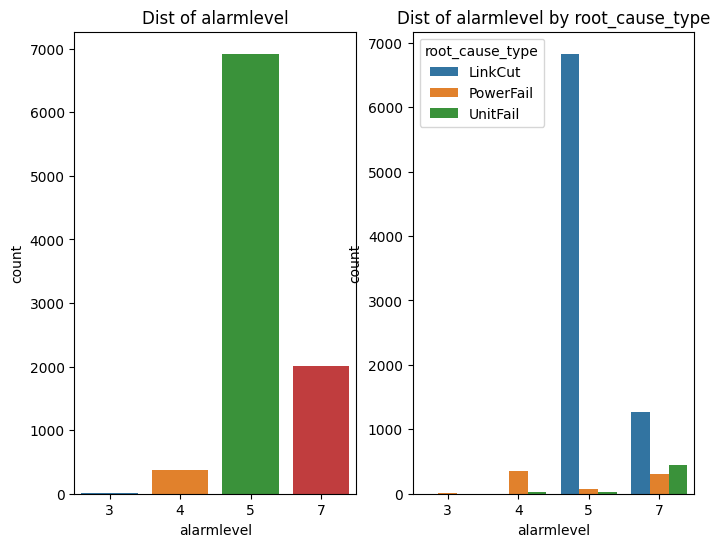

In [ ]:
# alarmlevel별 타겟 분포 그래프
fig = plt.figure(figsize = (8, 6))


ax1 = fig.add_subplot(1, 2, 1)
sns.countplot(x = 'alarmlevel', data = train_org, ax = ax1)
ax1.set_xlabel('alarmlevel')

ax1.set_title('Dist of alarmlevel')

ax2 = fig.add_subplot(1, 2, 2)
sns.countplot(x = 'alarmlevel', data = train_org, hue ='root_cause_type', ax = ax2)
ax2.set_title('Dist of alarmlevel by root_cause_type')

plt.show()

<Axes: xlabel='root_cause_type', ylabel='count'>

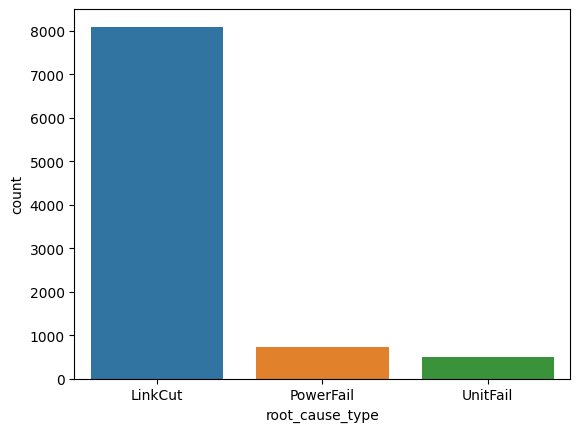

In [ ]:
# 타겟 분포 그래프
sns.countplot(x='root_cause_type', data=train_org)